<a href="https://colab.research.google.com/github/juhee3199/credit_score_predict/blob/main/code/credit_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- credit이 0에 가까울 수록 좋은 것
- 해당자가 그 행에 대응되는 신용카드를 발급받은 이후 데이터 수집일까지의 대금 연체 정도

In [146]:
!pip install --upgrade pandas==1.2

     |████████████████████████████████| 9.9 MB 7.0 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.2.0 which is incompatible.


In [147]:
!pip install catboost
!pip install category_encoders

     |████████████████████████████████| 76.3 MB 20 kB/s 
     |████████████████████████████████| 82 kB 298 kB/s 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from collections import Counter
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool

In [162]:
#train = pd.read_csv('credit_card_data/open/train.csv')
#test = pd.read_csv('credit_card_data/open/test.csv')
#submit =  pd.read_csv('credit_card_data/open/sample_submission.csv')

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_credit_cart/credit_card_data/open/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_credit_cart/credit_card_data/open/test.csv')
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dacon_credit_cart/credit_card_data/open/sample_submission.csv')

train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [4]:
train.shape

(26457, 20)

In [5]:
len(train.index.unique())

26457

- 데이터 형 변환

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
# credit 형 변환
train = train.astype({'credit': 'object'})
print(train.dtypes)

index              int64
gender            object
car               object
reality           object
child_num          int64
income_total     float64
income_type       object
edu_type          object
family_type       object
house_type        object
DAYS_BIRTH         int64
DAYS_EMPLOYED      int64
FLAG_MOBIL         int64
work_phone         int64
phone              int64
email              int64
occyp_type        object
family_size      float64
begin_month      float64
credit            object
dtype: object


# 데이터 전처리

### 1) 결측치 확인 및 처리
occyp_type 직업 유형에서 null 값이 있는 것을 확인

In [33]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [163]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

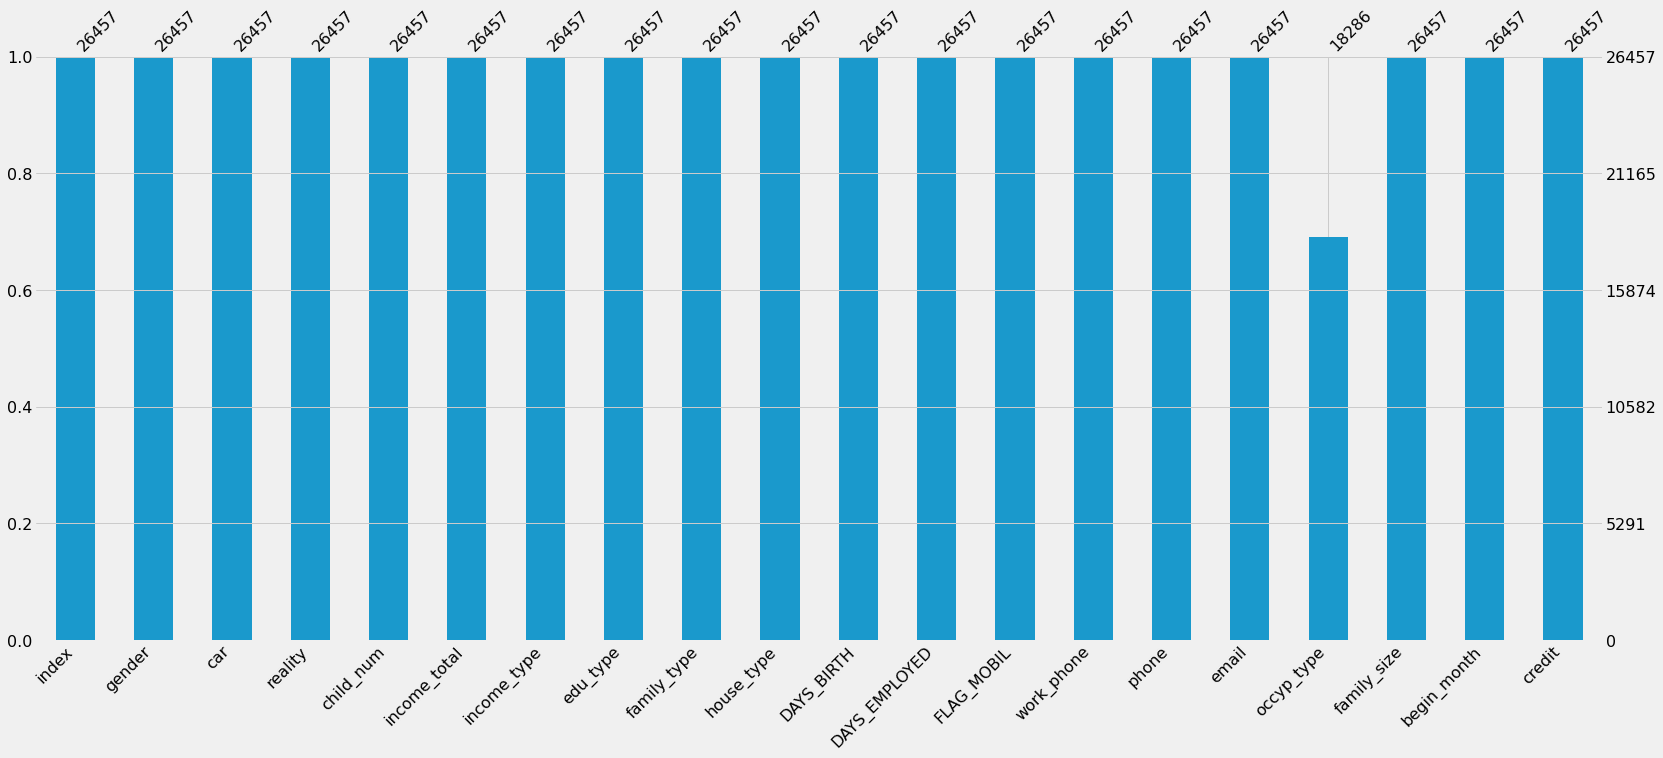

In [34]:
import missingno as msno
msno.bar(df=train.iloc[:, :], color=(0.1, 0.6, 0.8))

occyp_type 변수의 null 값 대체

- DAYS_EMPLOYED 가 양수인 경우, 무직을 의미하므로 No job으로 대체
- 이외 값은 제거하고 EDA 확인
- DAYS_EMPLOYED: 업무 시작일. 데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미 양수 값은 고용되지 않은 상태를 의미함

In [53]:
# 결측치
print(len(train[train['occyp_type'].isnull()]))

# 결측치 중 무직인 경우
print(len(train[train.DAYS_EMPLOYED >0]))

8171
4438


In [54]:
# 결측치 제거
# occyp_type이 nan이면서 취직을 한 경우
nan_index = train[(train['DAYS_EMPLOYED'] <= 0) & (train['occyp_type'].isnull()) ].index
train = train.drop(nan_index)

# 무직인 경우 NO job으로 대체
# occyp_type이 nan이면서 취직을 하지 않은 경우
train = train.fillna({'occyp_type':'No job'})  # 4438 row
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0


In [56]:
train[train.occyp_type == 'No job'][:3]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,No job,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,No job,2.0,-37.0,2.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,No job,2.0,-7.0,2.0


### 2) 중복 값 확인 및 처리
- family_size가 7, 15, 9인 데이터에서 중복된 사용자가 있음을 확인. (begin_month feature를 제외하고 모든 컬럼에서 동일한 값을 가짐.)
- 이외에도 중복된 사용자가 있는지 확인

In [42]:
print(train.shape)
print(len(train.index.unique()))

train[train.duplicated()]

(22724, 20)
22724


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit


- begin_month와 month와 다른 값을 가지고, 모든 컬럼의 값이 같다면 중복 값이라고 볼 수 있음
- 이를 어떻게 처리할 것인가. 어떤 값을 남길 것인가

In [57]:
train.family_size.unique()

array([ 3.,  2.,  4.,  1.,  6.,  5.,  7., 15., 20.,  9.])

In [58]:
train['family_size'].value_counts()

2.0     12160
1.0      4488
3.0      3873
4.0      1911
5.0       238
6.0        39
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [49]:
train[train.family_size==7] # 중복된 사용자 존재

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2296,2671,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-11.0,2.0
8200,9615,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-19.0,1.0
8818,10321,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-46.0,0.0
11021,12876,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-15.0,1.0
15093,17560,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-20.0,1.0
15441,17978,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-21.0,1.0
17006,19792,M,Y,Y,5,202500.0,Working,Secondary / secondary special,Married,Co-op apartment,-11384,-2727,1,0,0,0,Managers,7.0,-59.0,0.0
17285,20117,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-21.0,1.0
19421,22592,F,N,Y,5,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13039,-3375,1,0,0,0,Laborers,7.0,-10.0,1.0


In [59]:
train[train.family_size==15]
# 3명은 중복된 사용자임.


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
8462,8462,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-7.0,2.0
9021,9021,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-58.0,2.0
25390,25390,M,Y,Y,14,225000.0,Working,Secondary / secondary special,Separated,House / apartment,-17754,-1689,1,0,0,0,Drivers,15.0,-43.0,2.0


In [60]:
train[train.family_size==9] # 두 데이터는 동일한 사용자

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
25313,25313,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,1,1,1,0,Cleaning staff,9.0,-26.0,2.0
25638,25638,F,N,N,7,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13827,-1649,1,1,1,0,Cleaning staff,9.0,-31.0,2.0


In [61]:
train[train.family_size==20]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
10731,10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11057,-1853,1,1,1,0,Waiters/barmen staff,20.0,-5.0,2.0


- 중복된 사용자 찾기 
  - begin_month와 credit을 제외하고 모든 컬럼의 값이 같은 경우 존재 
  -  한 명의 사용자가 여러 개의 카드를 만든 경우

In [134]:
# begin_month를 제외하고 같은 값을 가지는 행

same_user = train.copy()
same_user = same_user.drop(['index','begin_month'], axis=1)
len(same_user[same_user.duplicated()])

12238

In [135]:
# begin_month와 credit을 제외하고 같은 값을 가지는 행

same_user = same_user.drop(['credit'], axis=1)
len(same_user[same_user.duplicated()])

15138

- ID 변수 추가
  - begin_month와 credit을 제외하고 같은 값을 가지는 경우 동일한 사용자로 판단

In [167]:
for df in [train, test]:
  df['ID'] = \
  df['child_num'].astype(str) + '_' + df['income_total'].astype(str) + '_' +\
  df['DAYS_BIRTH'].astype(str) + '_' + df['DAYS_EMPLOYED'].astype(str) + '_' +\
  df['work_phone'].astype(str) + '_' + df['phone'].astype(str) + '_' + train['FLAG_MOBIL'].astype(str) +  '_' +\
  df['email'].astype(str) + '_' + df['family_size'].astype(str) + '_' +\
  df['gender'].astype(str) + '_' + df['car'].astype(str) + '_' +\
  df['reality'].astype(str) + '_' + df['income_type'].astype(str) + '_' +\
  df['edu_type'].astype(str) + '_' + df['family_type'].astype(str) + '_' +\
  df['house_type'].astype(str) + '_' + df['occyp_type'].astype(str)

In [168]:
# ordinal_encoder 변환 후 정수 처리

encoder = OrdinalEncoder('ID')
train['ID'] = encoder.fit_transform(train['ID'])
test['ID'] = encoder.transform(test['ID'])

train['ID'] = train['ID'].astype('int64')
test['ID'] = test['ID'].astype('int64')
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,1
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,2
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,3
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,4
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,5


In [152]:
train.shape

(22724, 21)

In [155]:
len(train.ID.unique())

7586

### 3) 이상치 확인 및 처리
- family_size >  7 이상인 데이터

In [170]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit,ID
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560,3347.579091
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283,2309.081915
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000,1.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000,1384.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000,2969.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000,5057.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000,8759.000000


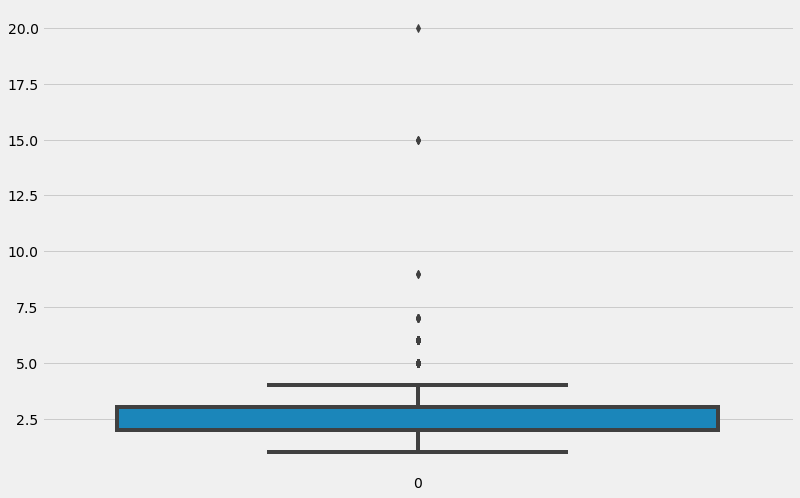

In [171]:
plt.figure(figsize=(12,8))
sns.boxplot(data= train['family_size'])
plt.show()

In [172]:
train = train[(train['family_size'] <= 7)]
train = train.reset_index(drop=True)

# EDA & Feature Engineering

### 2) Categorical Variable EDA

In [10]:
# 범주형 데이터 확인

train.income_type.unique(), train.edu_type.unique(), train.family_type.unique(), train.house_type.unique()

(array(['Commercial associate', 'Working', 'State servant', 'Pensioner',
        'Student'], dtype=object),
 array(['Higher education', 'Secondary / secondary special',
        'Incomplete higher', 'Lower secondary', 'Academic degree'],
       dtype=object),
 array(['Married', 'Civil marriage', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Municipal apartment', 'House / apartment', 'With parents',
        'Co-op apartment', 'Rented apartment', 'Office apartment'],
       dtype=object))

#### credit: 신용 등급 비율 (**target**)
- 낮을수록 높은 신용의 신용카드 사용자를 의미 
- 신용이 낮은 사용자가 많음

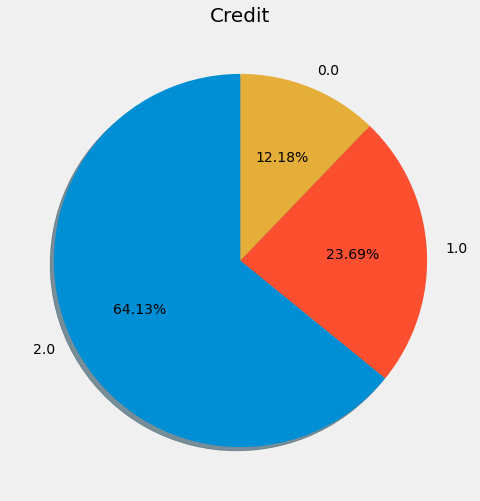

In [11]:
plt.subplots(figsize = (8,8))
plt.pie(train['credit'].value_counts(), labels = train['credit'].value_counts().index, 
        autopct="%.2f%%", shadow = True, startangle = 90)
plt.title('Credit', size=20)
plt.show()

In [12]:
# 등급에 따른 차이를 보기 위해 데이터 분류
train_0 = train[train['credit']==0.0]
train_1 = train[train['credit']==1.0]
train_2 = train[train['credit']==2.0]


# Categorical 그래프 함수 정의
def cat_plot(column):

  f, ax = plt.subplots(1, 3, figsize=(16, 6))


  sns.countplot(x = column,
                data = train_0,
                ax = ax[0],
                order = train_0[column].value_counts().index)
  ax[0].tick_params(labelsize=12)
  ax[0].set_title('credit = 0')
  ax[0].set_ylabel('count')
  ax[0].tick_params(rotation=50)


  sns.countplot(x = column,
                data = train_1,
                ax = ax[1],
                order = train_1[column].value_counts().index)
  ax[1].tick_params(labelsize=12)
  ax[1].set_title('credit = 1')
  ax[1].set_ylabel('count')
  ax[1].tick_params(rotation=50)

  sns.countplot(x = column,
                data = train_2,
                ax = ax[2],
                order = train_2[column].value_counts().index)
  ax[2].tick_params(labelsize=12)
  ax[2].set_title('credit = 2')
  ax[2].set_ylabel('count')
  ax[2].tick_params(rotation=50)
  plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

#### gender

- 남녀 비율 차이가 2배가 나타남

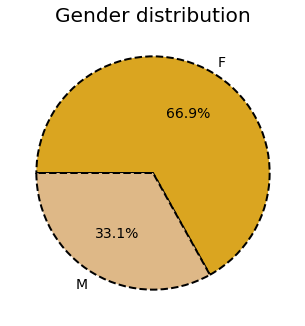

In [13]:
train1= train.groupby('gender').count()['index']
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['goldenrod','burlywood'], startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Gender distribution')
plt.show()

신용등급에 따라 성별 차이가 존재하는지 확인
- 모든 등급에서 남성보다 여성이 더 많음

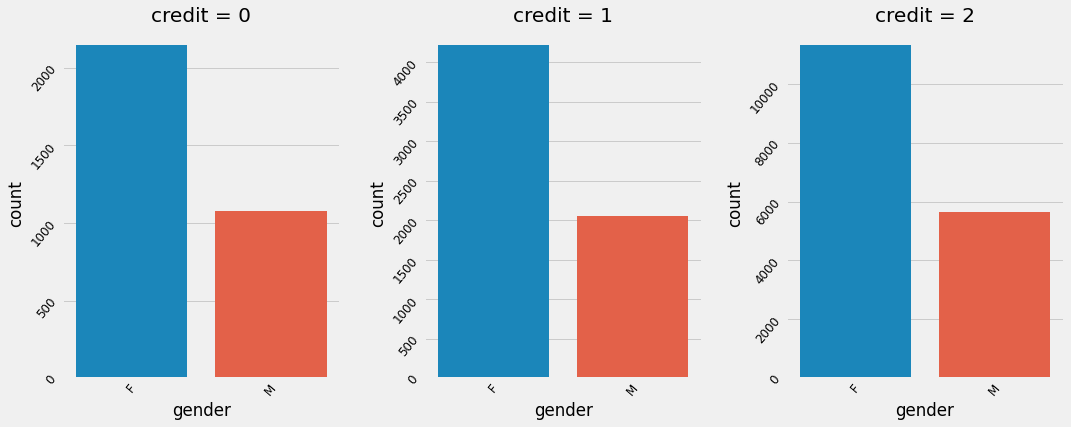

In [14]:
cat_plot("gender")

#### car

- 차를 소유하지 않은 사람이 2배 더 많음

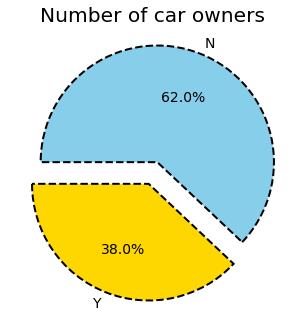

In [15]:
train1= train.groupby('car').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()


신용등급에 따라 차량 소유 차이가 존재하는지 확인
- 모든 등급에서 차를 보유하고 있지 않은 사람이 매우 많음

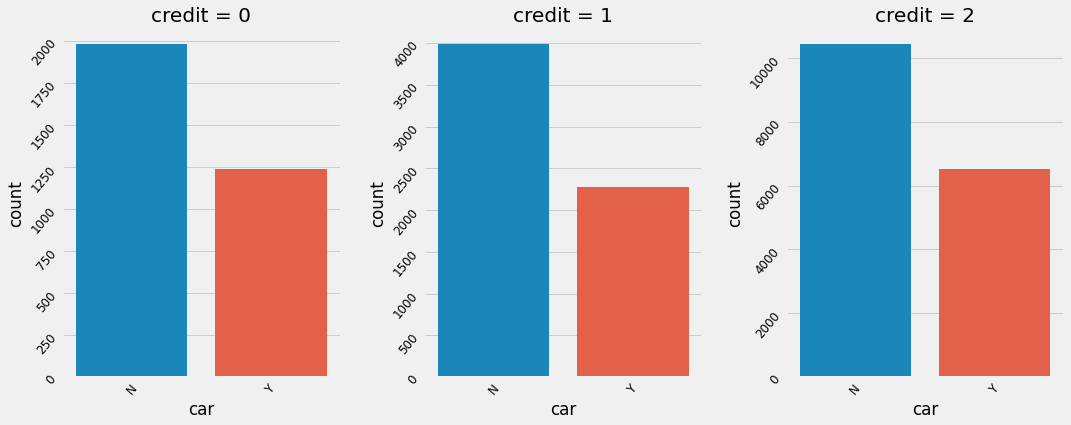

In [16]:
cat_plot('car')

#### reality
신용등급에 따라 부동산 소유 차이가 존재하는지 확인
- 모든 등급에서 부동산을 소유한 사람들이 많음
- 등급에 따른 차이가 존재하지 않는다.

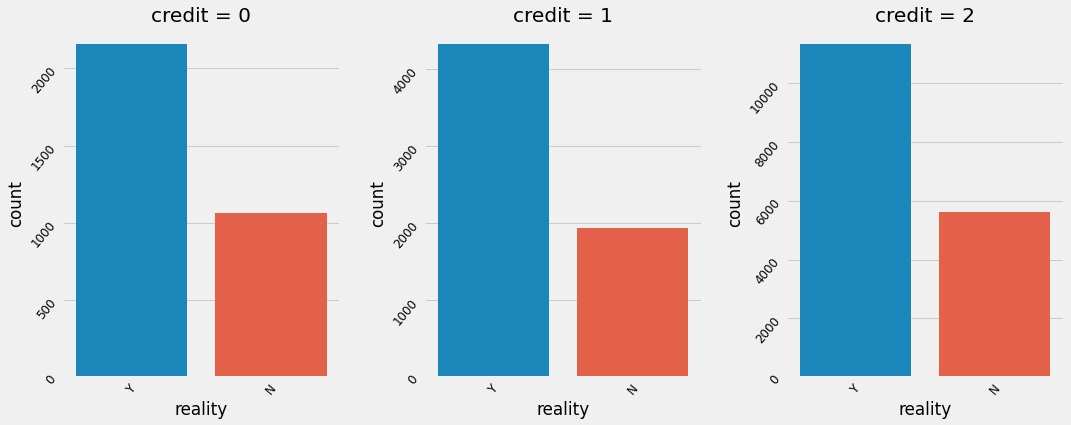

In [17]:
cat_plot('reality')

#### income_type
신용등급에 따라 소득 분류 차이가 존재하는지 확인
- 높은 신용에서는 학생이 존재하지 않음

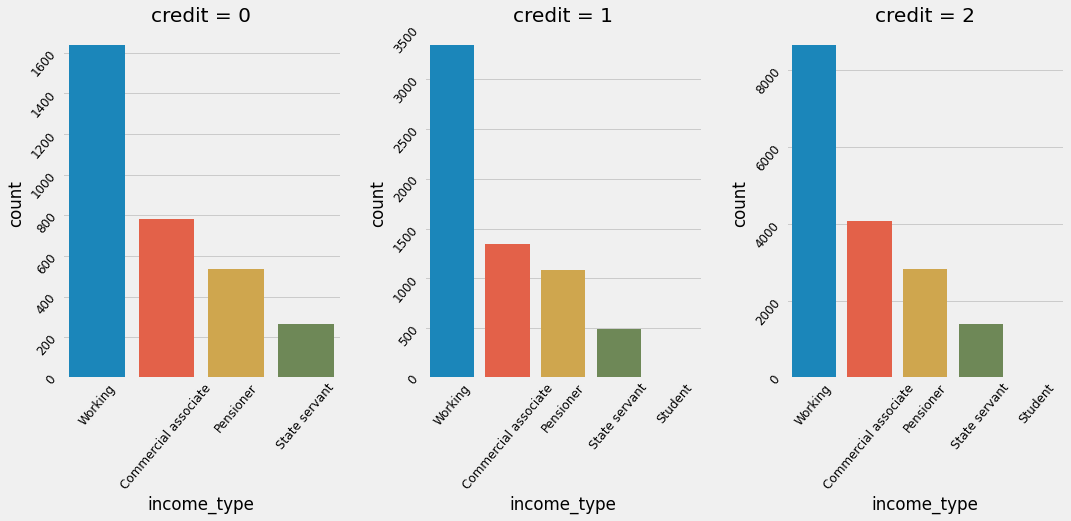

In [18]:
cat_plot('income_type') 

#### edu_type
신용등급에 따라 교육 수준 차이가 존재하는지 확인
- 모든 등급에서 모든 등급에서 교육 수준의 순위가 같음

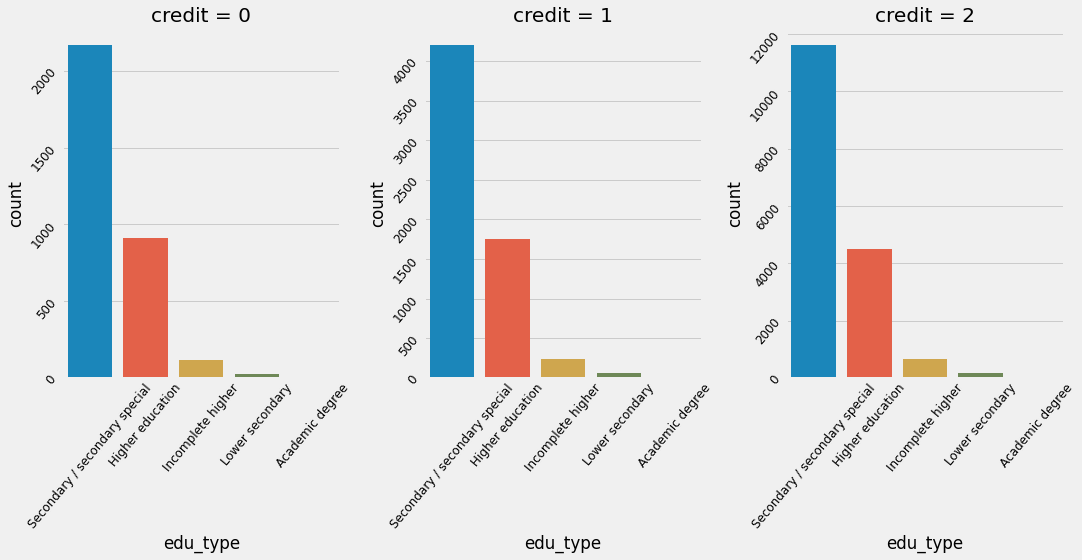

In [19]:
cat_plot('edu_type')

#### family_type
신용등급에 따라 결혼 여부 차이가 존재하는지 확인
- 모든 등급에서 결혼을 한 사람들이 매우 많음

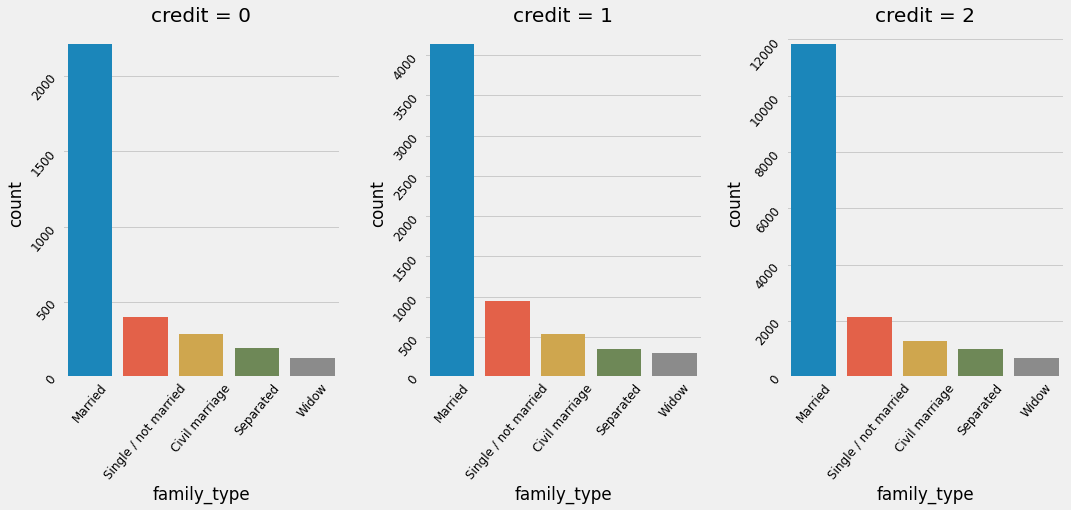

In [20]:
cat_plot('family_type')

#### house_type
신용등급에 따라 생활방식 차이가 존재하는지 확인
- 모든 등급에서 교육 수준의 순위가 같음

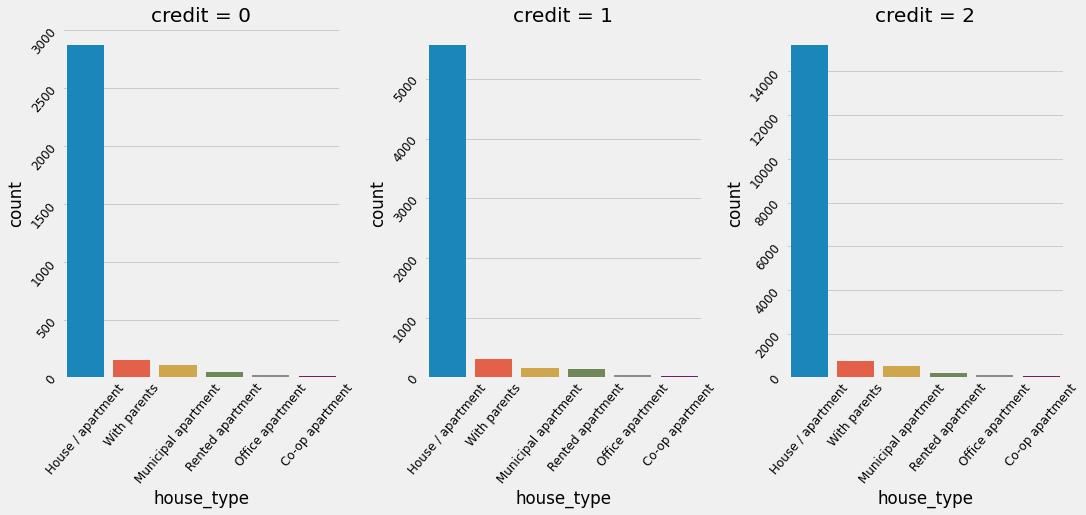

In [21]:
cat_plot('house_type')

#### FLAG_MOBIL
신용등급에 따라 휴대폰 소지 차이가 존재하는지 확인
- 모든 사람들이 휴대폰을 소지함
- 해당 컬럼 삭제하기

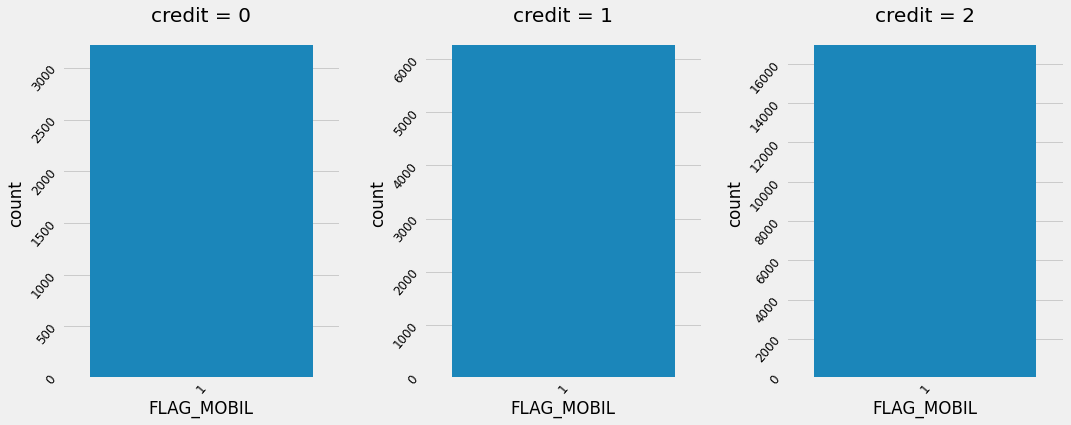

In [22]:
cat_plot('FLAG_MOBIL')

#### work_phone
신용등급에 따라 업무용 전화 소유 차이가 존재하는지 확인

- 모든 등급에서 업무용 전화를 소유하고 있지 않는 사람들이 많음
- 예측에 중요한 feature는 아니라고 판단

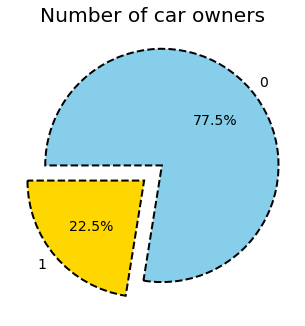

In [ ]:
train1= train.groupby('work_phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()

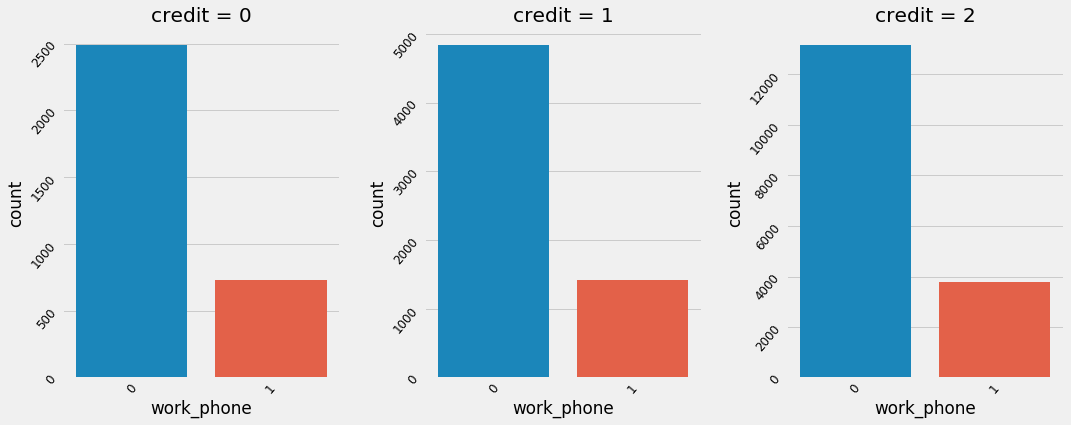

In [ ]:
cat_plot('work_phone')

#### phone
신용등급에 따라 가정용 전화 소유 차이가 존재하는지 확인

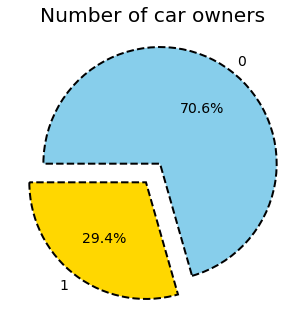

In [ ]:
train1= train.groupby('phone').count()['index']
explode = (0.1, 0.1)
fig = plt.figure(figsize=(5,5)) ## 캔버스 생성
fig.set_facecolor('white')
plt.pie(train1, labels=train1.index,colors=['skyblue','gold'],explode=explode, startangle=180,autopct='%1.1f%%',counterclock=False,wedgeprops = {'edgecolor':'k','linestyle':'--','linewidth':2})
plt.title('Number of car owners')
plt.show()

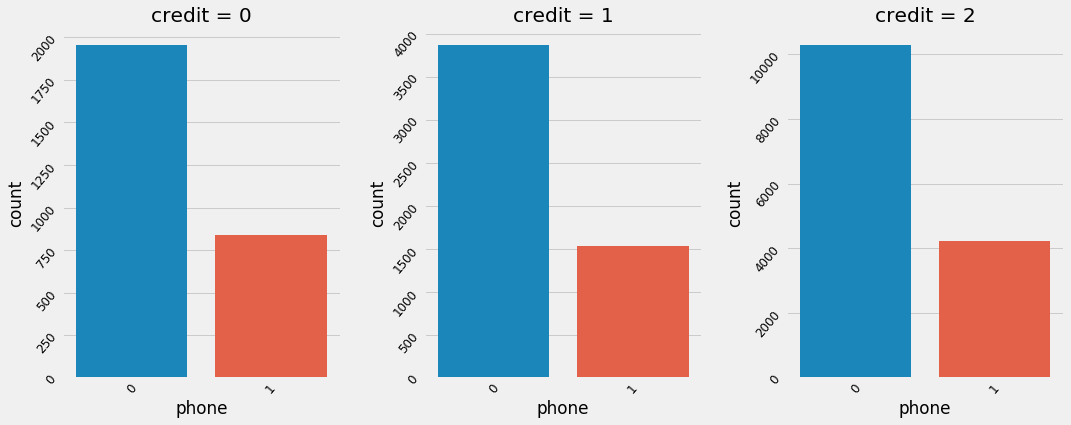

In [ ]:
cat_plot('phone')

#### email
신용등급에 따라 이메일 소유 차이가 존재하는지 확인
- 모든 등급에서 이메일을 소유한 사람들이 훨씬 많음

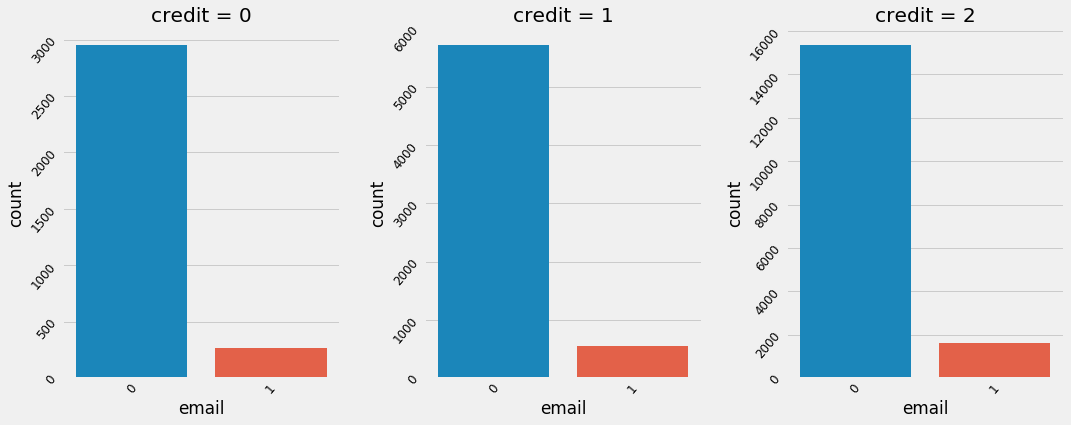

In [ ]:
cat_plot('email')

### occyp_type

1) 해당 변수의 결측치 처리 후, EDA 수행
- 해당 변수는 결측치가 존재했음. 
- DAYS_EMPLOYED 가 양수인 경우, 무직이므로 No job으로 대체
- 이외 값은 제거하고 EDA 확인

In [27]:
# 결측치
print(len(train[train['occyp_type'].isnull()]))

# 결측치 중 무직인 경우
print(len(train[train.DAYS_EMPLOYED >0]))

8171
4438


In [28]:
# 결측치 제거
# occyp_type이 nan이면서 취직을 한 경우
nan_index = train[(train['DAYS_EMPLOYED'] <= 0) & (train['occyp_type'].isnull()) ].index
train = train.drop(nan_index)

# 무직인 경우 NO job으로 대체
# occyp_type이 nan이면서 취직을 하지 않은 경우
train = train.fillna({'occyp_type':'No job'})  # 4438 row
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
5,5,F,N,Y,2,270000.0,Working,Secondary / secondary special,Married,House / apartment,-13413,-4996,1,0,0,1,High skill tech staff,4.0,-18.0,1.0


In [ ]:
train[train.occyp_type == 'No job']

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22922,365243,1,0,1,0,No job,1.0,-41.0,2.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23113,365243,1,0,0,0,No job,2.0,-37.0,2.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21253,365243,1,0,1,0,No job,2.0,-7.0,2.0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22361,365243,1,0,1,0,No job,1.0,-5.0,2.0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21100,365243,1,0,1,0,No job,1.0,-24.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-21151,365243,1,0,0,1,No job,1.0,-60.0,1.0
26432,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-22314,365243,1,0,1,0,No job,2.0,-17.0,1.0
26439,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-19238,365243,1,0,0,0,No job,2.0,-57.0,2.0
26441,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,-24129,365243,1,0,0,0,No job,1.0,-43.0,2.0


2) 신용등급에 따라 직업 유형 차이가 존재하는지 확인
- 등급별로 직업 유형의 순위 변동이 조금 존재

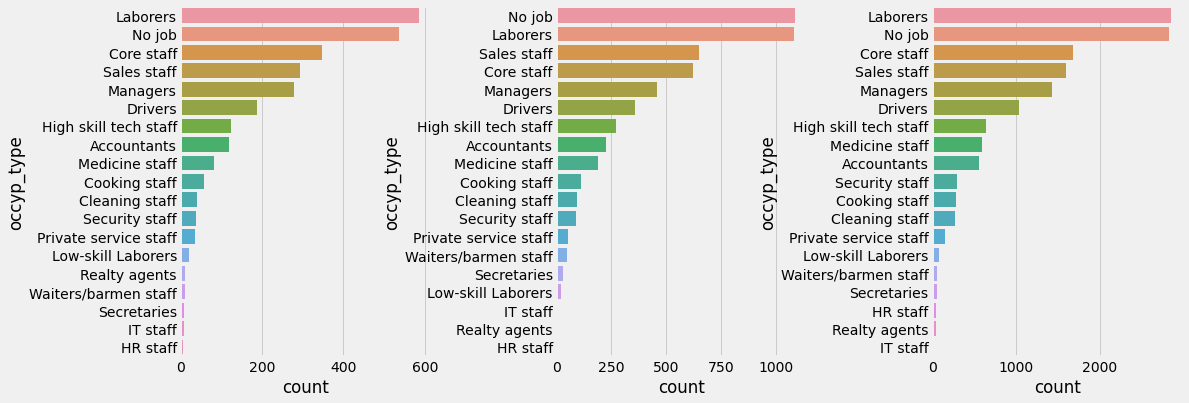

In [29]:
train_0 = train[train.credit == 0]
train_1 = train[train.credit == 1]
train_2 = train[train.credit == 2]


f, ax = plt.subplots(1, 3, figsize=(16, 6))
sns.countplot(y = 'occyp_type', data = train_0, order = train_0['occyp_type'].value_counts().index, ax=ax[0])
sns.countplot(y = 'occyp_type', data = train_1, order = train_1['occyp_type'].value_counts().index, ax=ax[1])
sns.countplot(y = 'occyp_type', data = train_2, order = train_2['occyp_type'].value_counts().index, ax=ax[2])
plt.subplots_adjust(wspace=0.5, hspace=0.3)
plt.show()

## 3) Numerical Variable EDA

In [ ]:
train.describe()

,index,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,13228.000000,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,7637.622372,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,6614.000000,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,13228.000000,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,19842.000000,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,26456.000000,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [ ]:
# Numerical 그래프 함수 정의
def num_plot(column):
    
# 등급에 따른 차이를 보기 위해 데이터 분류
    train_0 = train[train['credit']==0.0]
    train_1 = train[train['credit']==1.0]
    train_2 = train[train['credit']==2.0]


    fig, axes = plt.subplots(1, 3, figsize=(16, 6))


    sns.distplot(train_0[column],
                ax = axes[0])
    axes[0].tick_params(labelsize=12)
    axes[0].set_title('credit = 0')
    axes[0].set_ylabel('count')

    sns.distplot(train_1[column],
                ax = axes[1])
    axes[1].tick_params(labelsize=12)
    axes[1].set_title('credit = 1')
    axes[1].set_ylabel('count')

    sns.distplot(train_2[column],
                ax = axes[2])
    axes[2].tick_params(labelsize=12)
    axes[2].set_title('credit = 2')
    axes[2].set_ylabel('count')
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

#### child_num
신용등급에 따라 자녀수 차이가 존재하는지 확인
- 등급별 차이가 거의 없음

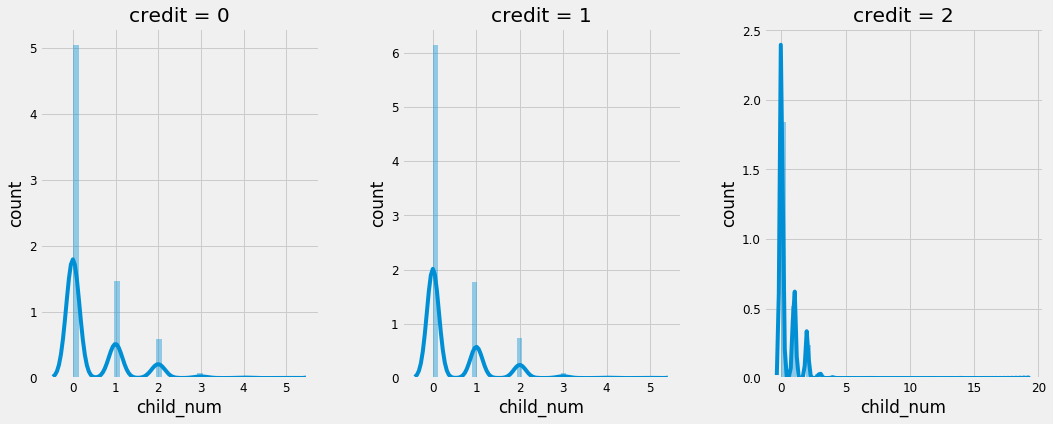

In [ ]:
num_plot("child_num")

#### income_total
신용등급에 따라 연간 소득 차이가 존재하는지 확인
- 등급별 차이가 거의 없음

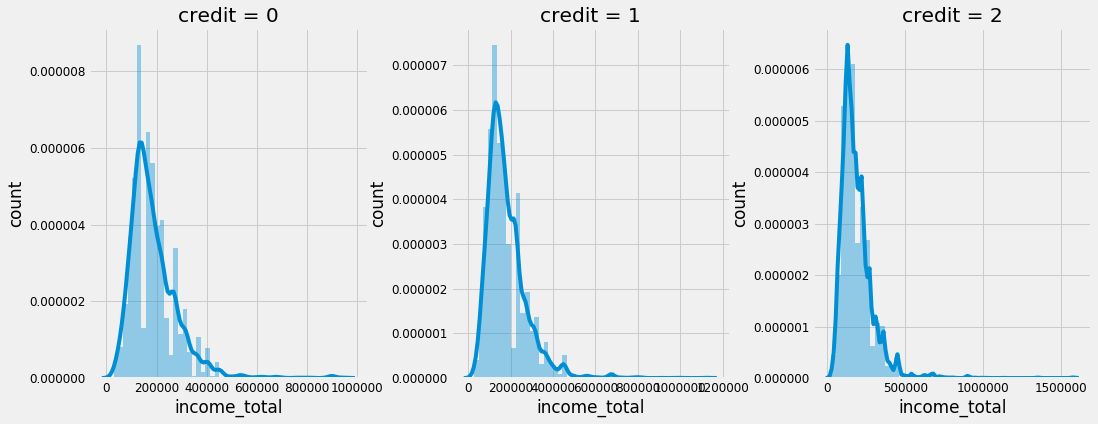

In [ ]:
num_plot("income_total")

#### DAYS_BIRTH, Age
Age 변수 생성 후, 분포 확인

- 30, 40, 50대가 주를 이루고 있음

In [ ]:
train['Age'] = abs(train['DAYS_BIRTH'])/360

train = train.astype({'Age': 'int'})
train['Age'].head()

1    31
2    53
3    41
4    41
5    37
Name: Age, dtype: int32

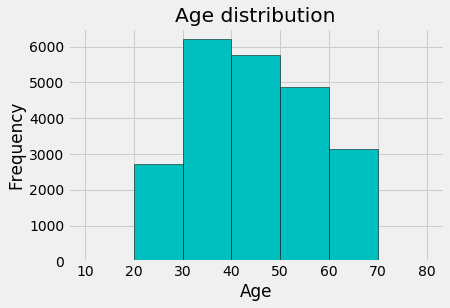

In [ ]:
train['Age'].plot.hist(bins=range(10,81,10),color='c', edgecolor='k')
plt.xlabel('Age')
plt.title('Age distribution')
plt.show()

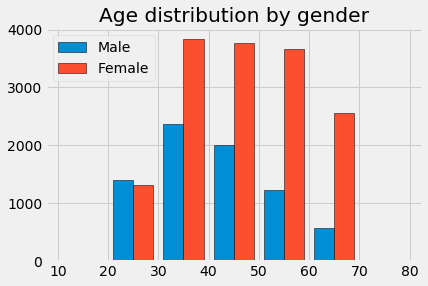

In [ ]:
# 성별에 따른 분포
sex = train.groupby('gender')
M_group= sex.get_group('M')
F_group= sex.get_group('F')
M = M_group['Age']
F = F_group['Age']

plt.hist([M,F], bins=range(10,81,10), label=['Male', 'Female'],edgecolor='k')
plt.legend(loc='upper left')
plt.title('Age distribution by gender')
plt.show()

신용등급에 따라 연령대 차이가 존재하는지 확인
- 등급별 차이가 거의 없음. 모든 등급에서 20~30대 비율이 낮음

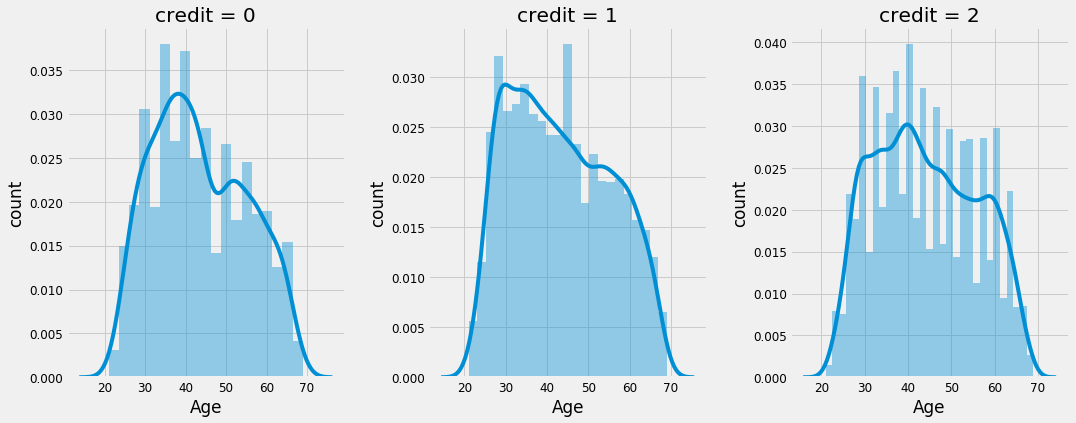

In [ ]:
train['Age'] = abs(train['DAYS_BIRTH'])/360
train = train.astype({'Age': 'int'})

num_plot("Age")

#### DAYS_EMPLOYED, days_employed
- employed 변수 생성 후, 신용등급에 따라 업무 기간 차이가 존재하는지 확인
- 양수는 무직을 의미하므로 0으로 대체


- 대체적으로 직업이 없는 사람들이 많음
- 등급별 차이가 거의 없음

In [ ]:
train['days_employed']= train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)
train['days_employed'] = abs(train['days_employed'])/360
train = train.astype({'days_employed': 'int'})

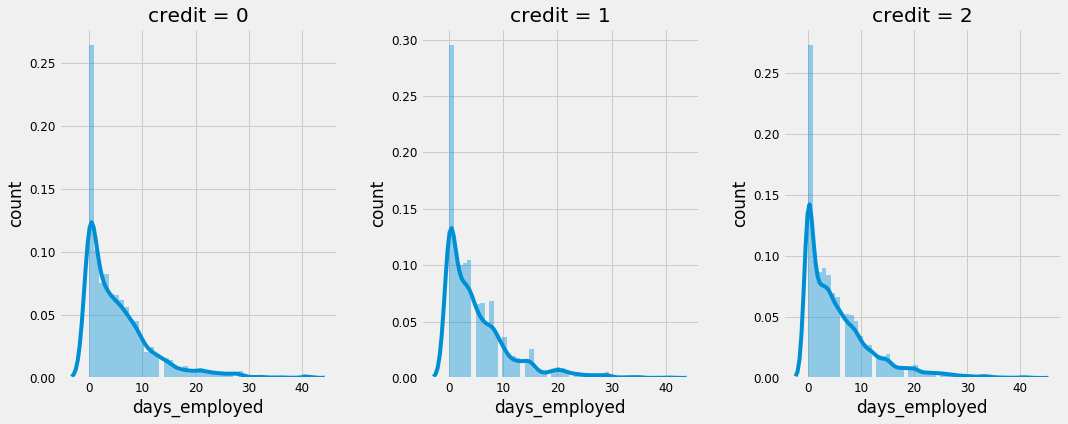

In [ ]:
num_plot("days_employed")

#### family_size
신용등급에 따라 가족 수 차이가 존재하는지 확인

- 보통 가족 수가 2명인 사람들이 많음
- 결혼한 사람들이 많았던 결과와 연관되는 결과
- 2등급에서는 1,2에 비해 왼쪽으로 치우진 그래프가 나옴

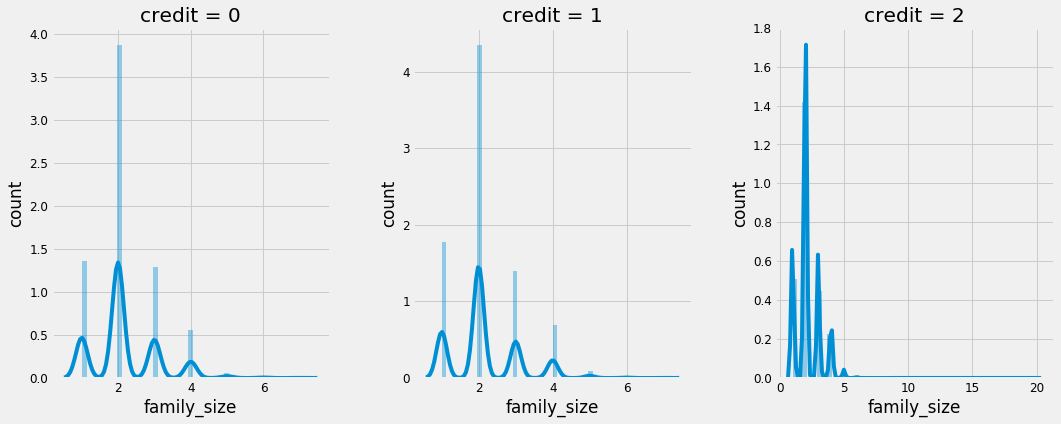

In [ ]:
num_plot("family_size")

#### begin_month
- 신용등급에 따라 카드 발급 기간 차이가 존재하는지 확인
- 대부분 카드를 발급 받은지 10달 이하인 사람들이 많음

In [ ]:
train['begin_month'] = abs(train['begin_month'])
train = train.astype({'begin_month': 'int'})
train['begin_month'].head()

0     6
1     5
2    22
3    37
4    26
Name: Month, dtype: int32

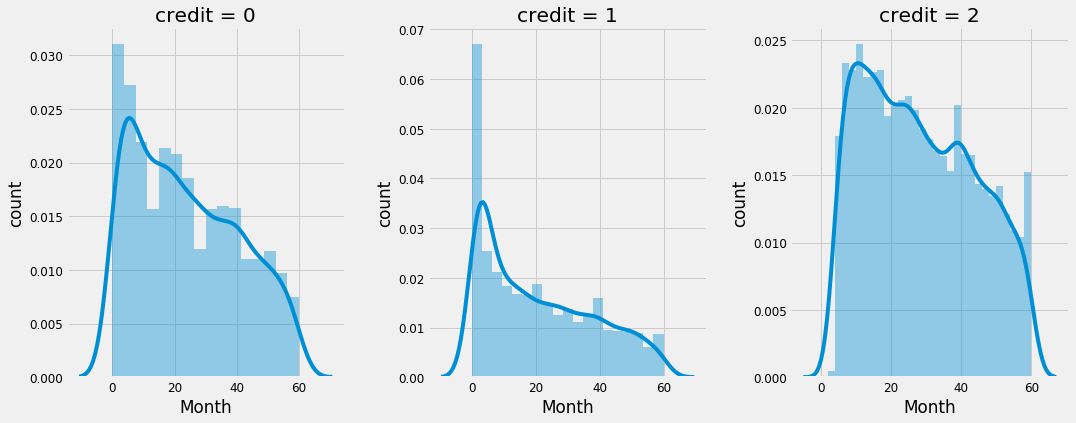

In [ ]:
num_plot("Month")

In [ ]:
num_plot("Month")

# 3. Feature engineering


1) 의미없는 변수 제거

- index 제거
- FLAG_MOBIL 컬럼 삭제
모든 사람들이 휴대폰을 소지함. 의미있는 feature가 아님

In [ ]:
train.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)
test.drop(['index', 'FLAG_MOBIL'], axis=1, inplace=True)

In [ ]:
train.family_size

2) 음수 값 양수로 변환

In [177]:
feats = ['DAYS_BIRTH', 'begin_month']
for feat in feats:
    train[feat]=np.abs(train[feat])
    test[feat]=np.abs(test[feat])

3) 파생변수

- employed : 고용 여부
- employed_y : 근속 연수

In [178]:
# 고용상태면 employed=1
# DAYS_EMPLOYED가 음수면 employed=1

train['employed'] = np.where(train['DAYS_EMPLOYED']<0, 1, 0)
test['employed'] = np.where(test['DAYS_EMPLOYED']<0, 1, 0)

In [181]:
 df['employed_y'] = df['DAYS_EMPLOYED'] // 365

 df.employed_y.describe()

count    10000.000000
mean       163.242300
std        378.352827
min        -43.000000
25%         -9.000000
50%         -5.000000
75%         -2.000000
max       1000.000000
Name: employed_y, dtype: float64

In [182]:
 df['employed_y'] = np.abs(df['DAYS_EMPLOYED']) // 365

 df.employed_y.describe()

count    10000.000000
mean       175.328000
std        372.889428
min          0.000000
25%          3.000000
50%          6.000000
75%         15.000000
max       1000.000000
Name: employed_y, dtype: float64

In [185]:
df['DAYS_EMPLOYED'].describe()

count     10000.000000
mean      59776.690400
std      138121.224504
min      -15661.000000
25%       -3153.000000
50%       -1577.000000
75%        -410.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [187]:
df = train.copy()

# before_EMPLOYED: 고용되기 전까지의 일수
df['before_EMPLOYED'] = df['DAYS_BIRTH'] - df['DAYS_EMPLOYED']
df['income_total_befofeEMP_ratio'] = df['income_total'] / df['before_EMPLOYED']
df['before_EMPLOYED_m'] = np.floor(df['before_EMPLOYED'] / 30) - ((np.floor(df['before_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['before_EMPLOYED_w'] = np.floor(df['before_EMPLOYED'] / 7) - ((np.floor(df['before_EMPLOYED'] / 7) / 4).astype(int) * 4)

#DAYS_BIRTH 파생변수- Age(나이), 태어난 월, 태어난 주(출생연도의 n주차)
df['Age'] = df['DAYS_BIRTH'] // 365
df['DAYS_BIRTH_m'] = np.floor(df['DAYS_BIRTH'] / 30) - ((np.floor(df['DAYS_BIRTH'] / 30) / 12).astype(int) * 12)
df['DAYS_BIRTH_w'] = np.floor(df['DAYS_BIRTH'] / 7) - ((np.floor(df['DAYS_BIRTH'] / 7) / 4).astype(int) * 4)


#DAYS_EMPLOYED_m 파생변수- EMPLOYED(근속연수), DAYS_EMPLOYED_m(고용된 달) ,DAYS_EMPLOYED_w(고용된 주(고용연도의 n주차))  
df['EMPLOYED'] = df['DAYS_EMPLOYED'] // 365
df['DAYS_EMPLOYED_m'] = np.floor(df['DAYS_EMPLOYED'] / 30) - ((np.floor(df['DAYS_EMPLOYED'] / 30) / 12).astype(int) * 12)
df['DAYS_EMPLOYED_w'] = np.floor(df['DAYS_EMPLOYED'] / 7) - ((np.floor(df['DAYS_EMPLOYED'] / 7) / 4).astype(int) * 4)

In [190]:
df['DAYS_EMPLOYED'].describe()

count     26451.000000
mean      59082.535859
std      137487.971901
min      -15713.000000
25%       -3153.000000
50%       -1539.000000
75%        -407.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [193]:
df['EMPLOYED'].describe()

count    26451.000000
mean       161.341008
std        376.618089
min        -44.000000
25%         -9.000000
50%         -5.000000
75%         -2.000000
max       1000.000000
Name: EMPLOYED, dtype: float64

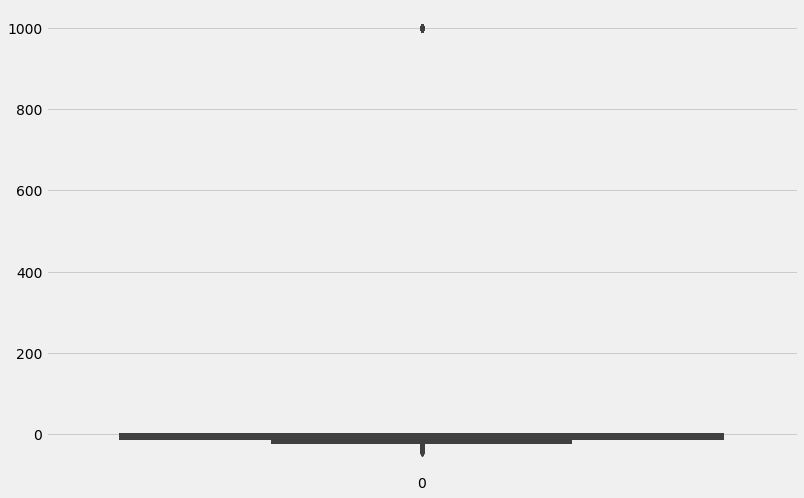

In [195]:

plt.figure(figsize=(12,8))
sns.boxplot(data= df['EMPLOYED'])
plt.show()

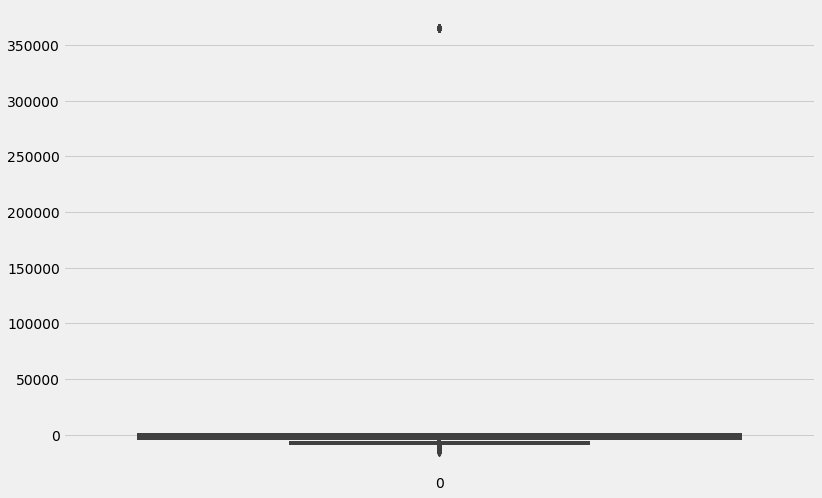

In [191]:
plt.figure(figsize=(12,8))
sns.boxplot(data= train['DAYS_EMPLOYED'])
plt.show()

In [196]:
df[df['DAYS_EMPLOYED']>df['DAYS_BIRTH']] # 

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,ID,employed,before_EMPLOYED,income_total_befofeEMP_ratio,before_EMPLOYED_m,before_EMPLOYED_w,Age,DAYS_BIRTH_m,DAYS_BIRTH_w,EMPLOYED,DAYS_EMPLOYED_m,DAYS_EMPLOYED_w
14,14,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,22922,365243,1,0,1,0,NaN,1.0,41.0,2.0,15,0,-342321,-0.460094,-11.0,-3.0,62,8.0,2.0,1000,6.0,1.0
18,18,F,N,Y,0,216000.0,Pensioner,Secondary / secondary special,Married,House / apartment,23113,365243,1,0,0,0,NaN,2.0,37.0,2.0,19,0,-342130,-0.631339,-5.0,0.0,63,2.0,1.0,1000,6.0,1.0
21,21,F,N,N,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,21253,365243,1,0,1,0,NaN,2.0,7.0,2.0,22,0,-343990,-0.457862,-7.0,-2.0,58,0.0,0.0,1000,6.0,1.0
24,24,F,N,N,0,202500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,22361,365243,1,0,1,0,NaN,1.0,5.0,2.0,25,0,-342882,-0.590582,-6.0,0.0,61,1.0,2.0,1000,6.0,1.0
46,46,F,N,N,0,135000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,21100,365243,1,0,1,0,NaN,1.0,24.0,2.0,47,0,-344143,-0.392279,0.0,0.0,57,7.0,2.0,1000,6.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26425,26431,F,N,Y,0,225000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,21151,365243,1,0,0,1,NaN,1.0,60.0,1.0,6767,0,-344092,-0.653895,-10.0,0.0,57,9.0,1.0,1000,6.0,1.0
26426,26432,F,Y,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,22314,365243,1,0,1,0,NaN,2.0,17.0,1.0,1498,0,-342929,-0.209956,-7.0,-2.0,61,11.0,3.0,1000,6.0,1.0
26433,26439,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Married,House / apartment,19238,365243,1,0,0,0,NaN,2.0,57.0,2.0,8421,0,-346005,-0.195084,-2.0,-2.0,52,5.0,0.0,1000,6.0,1.0
26435,26441,F,N,Y,0,90000.0,Pensioner,Incomplete higher,Separated,House / apartment,24129,365243,1,0,0,0,NaN,1.0,43.0,2.0,4727,0,-341114,-0.263841,-7.0,-3.0,66,0.0,3.0,1000,6.0,1.0


- age 컬럼 생성

In [ ]:
# DAYS_BIRTH는 출생일을 의미. 해당 값을 나이로 변환

train['age'] = round(train.DAYS_BIRTH/365)

train = train.drop(['DAYS_BIRTH'], axis=1)
train['age'].describe()

count    26457.000000
mean        43.731186
std         11.521771
min         21.000000
25%         34.000000
50%         43.000000
75%         53.000000
max         69.000000
Name: age, dtype: float64

- income_mean: 소득 / 가족 수 = income_total/family_size

In [ ]:
 #income_mean: 소득/ 가족 수
df['income_mean'] = df['income_total'] / df['family_size']

# 4. 모델링

In [ ]:
train = train.drop(['index','occyp_type'], axis=1)
train.shape

In [ ]:
x_train = train.drop(['credit'], axis =1)
y_train = train['credit']
x_train.head(3)

## 1) pycaret


In [ ]:
!pip install pycaret

     |████████████████████████████████| 266 kB 5.3 MB/s 
     |████████████████████████████████| 80 kB 12.1 MB/s 
     |████████████████████████████████| 56 kB 5.5 MB/s 
     |████████████████████████████████| 167 kB 74.3 MB/s 
     |████████████████████████████████| 2.0 MB 73.6 MB/s 
     |████████████████████████████████| 16.9 MB 44 kB/s 
     |████████████████████████████████| 1.7 MB 91.9 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 111 kB 75.0 MB/s 
     |████████████████████████████████| 1.3 MB 77.7 MB/s 
     |████████████████████████████████| 271 kB 76.4 MB/s 
     |████████████████████████████████| 6.8 MB 49.0 MB/s 
     |████████████████████████████████| 261 kB 62.7 MB/s 
     |████████████████████████████████| 3.1 MB 73.0 MB/s 
     |████████████████████████████████| 596 kB 79.0 MB/s 
     |██████████████████

In [ ]:
from pycaret.classification import *
from sklearn.metrics import log_loss

C:\anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [ ]:
clf = setup(data=train, target='credit', train_size=0.85)

,Description,Value
0,session_id,1090
1,Target,credit
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(26457, 18)"
5,Missing Values,False
6,Numeric Features,5
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

Name                                                           LogLoss
Display Name                                                   LogLoss
Score Function               <function log_loss at 0x000001C69DF86B70>
Scorer               make_scorer(log_loss, greater_is_better=False,...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: logloss, dtype: object

In [ ]:
# 데이터에 적합한 모델 찾기

#svm, ridge는 predict_proba 미지원으로 제외
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6953,0.6976,0.4244,0.6895,0.6179,0.2341,0.3177,0.7732,2.036
gbc,Gradient Boosting Classifier,0.6899,0.6538,0.409,0.6537,0.6037,0.2086,0.3014,0.7989,10.32
lda,Linear Discriminant Analysis,0.6395,0.6086,0.3358,0.5278,0.5032,0.0076,0.0384,0.8651,0.266
nb,Naive Bayes,0.6407,0.6067,0.3357,0.5466,0.5025,0.008,0.0496,0.867,0.166
lr,Logistic Regression,0.639,0.5863,0.3333,0.4083,0.4982,0,0,0.8735,8.298
rf,Random Forest Classifier,0.6946,0.7412,0.5269,0.6707,0.6753,0.3555,0.3636,0.9859,3.3
ada,Ada Boost Classifier,0.6885,0.627,0.4039,0.6269,0.5985,0.1978,0.299,1.081,1.186
et,Extra Trees Classifier,0.6682,0.7039,0.5137,0.6464,0.6529,0.3126,0.3172,2.639,4.294
knn,K Neighbors Classifier,0.6119,0.6531,0.4555,0.5871,0.596,0.2009,0.2036,4.017,1.488
dt,Decision Tree Classifier,0.6009,0.6346,0.4859,0.6114,0.6058,0.2489,0.2492,13.36,0.422


In [ ]:
blended = blend_models(estimator_list = best5, fold = 5, optimize = 'logloss')
pred_holdout = predict_model(blended)

IntProgress(value=0, description='Processing: ', max=6)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:42:18
Status,. . . . . . . . . . . . . . . . . .,Finalizing Model
Estimator,. . . . . . . . . . . . . . . . . .,Voting Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss


BrokenProcessPool: A result has failed to un-serialize. Please ensure that the objects returned by the function are always picklable.

In [ ]:
#lda 와 nb는 losloss가 좋지만 accuracy, auc가 상대적으로 좋지 않아 커스텀모델 생성
custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['lightgbm','gbc','rf','ada', 'lda', 'nb'])

In [ ]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)

In [ ]:
#자동으로 상위 5개 선택한 모델
final_model = finalize_model(blended)

#Accurary, AUC, Logloss 셋다 상위 4개인 모델 
final_model_custom = finalize_model(blended_custom)


#Accurary, AUC, Logloss 셋다 상위 4개인 모델 사용
prep_pipe = get_config("prep_pipe")
prep_pipe.steps.append(['trained_model', final_model_custom])
prections = prep_pipe.predict_proba(test)
prections

In [ ]:
i, j, k = [], [], []
for row in prections:
  i.append(row[0])
  j.append(row[1])
  k.append(row[2])

len(i), len(j), len(k)

In [ ]:
submit['0'] = i
submit['1'] = j
submit['2'] = k
submit.head(10)

In [ ]:
submit.to_csv("\submisison.csv",index=False)

In [ ]:
total_models = []
models()

## 2) 최종 모델 학습

## 3) 최종 예측